In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import clone
import warnings


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (GridSearchCV, 
                                    train_test_split, KFold, 
                                    cross_val_score)

import rfpimp as rf
from tqdm import tqdm

from pyod.models.lof import LOF

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

# Кратко о представленной задаче #

Данная учебная задача была текущей аттестацией на курсе "Практический Machine Learning". 
Она представляет собой классическую задачу бинарной классификации, где необходимо было определить, является ли опухоль доброкачественной (0) или злокачественной (1).
Задача представлялась как закрытый хакатон на базе kaggle для студентов курса. Оценочным критерием принимался F1-score.
Мой результат занял 1-2 (одинаковое качество у первых двух мест) с показателем f1 = 0.97543 (скриншот в архиве).

## Подготавливаем тренировочный ДатаСет ##

In [2]:
# Данные для обучения разделены на 5 файлов, ключом между которыми является столбец 'ID'

# Подготовим адрес к соответствующим файлам
location_train = r'C:\Users\OlegD\Desktop\Machine Learning\mid-term hackaton\train'
df_train_list = [r'\train0.csv', r'\train1.csv', r'\train2.csv', r'\train3.csv', r'\train4.csv']

# Проверим заголовки столбцов
for item in df_train_list:
    df_train_n = pd.read_csv(location_train + item)
    print(df_train_n.columns.values)
    print('-' * 20)

['ID' 'Category' 'radius_mean' 'radius_std' 'radius_max' 'texture_mean'
 'texture_std']
-----------------------
['IT' 'Category' 'area_std' 'area_max' 'smoothness_mean' 'smoothness_std'
 'smoothness_max' 'compactness_mean' 'compactness_std' 'compactness_max'
 'concavity_mean' 'concavity_std' 'concavity_max']
-----------------------
['ID' 'Category' 'concave_points_mean' 'concave_points_std'
 'concave_points_max' 'symmetry_mean' 'symmetry_std' 'symmetry_max']
-----------------------
['1D' 'Category' 'texture_max' 'perimeter_mean' 'perimeter_std'
 'perimeter_max' 'area_mean']
-----------------------
['ID' 'Category' 'fractal_dimension_mean' 'fractal_dimension_std'
 'fractal_dimension_max']
-----------------------


In [3]:
# Видно, что есть 2 проблемы: 
# 1) Ошибки в заголовке 'ID' (первый в списке)
# 2) Повторение лейблов в каждом из 5 файлов

#Исправляем первую проблему
# Приводим все возможные вариации 'ID' к единому виду

meta_dataframe = [None] * len(df_train_list)
for n, item in enumerate(df_train_list):
    meta_dataframe[n] = pd.read_csv(location_train + item) 
    meta_dataframe[n].rename(columns={meta_dataframe[n].columns[0]: 'ID'}, inplace=True) 

In [4]:
# Исправляем вторую проблему:
    
y_train = meta_dataframe[0]['Category'] # Извлекаем столбец лейблов

# Удаляем 'Category' из каждого тренировочного ДатаСета
for n in range(len(df_train_list)):
    meta_dataframe[n].drop('Category', axis=1, inplace=True)

# Теперь объединим все тренировочные ДатаСеты в один; ключом будет 'ID'
X_train = meta_dataframe[0]
for n in range(1,len(df_train_list)):
    X_train = pd.merge(X_train, meta_dataframe[n], on='ID', how='left')

## Подготавливаем тестовый ДатаСет ##

In [5]:
# Он также состоит из 5 файлов.
location_test = r'C:\Users\OlegD\Desktop\Machine Learning\mid-term hackaton\test'
df_train_list = [r'\test0.csv', r'\test1.csv', r'\test2.csv', r'\test3.csv', r'\test4.csv']

# Т.к. заголовки в порядке, сразу объединим все тестовые ДатаСеты в один; ключом будет 'ID'
X_test_raw = pd.read_csv(location_test + r'\test0.csv')
for df in df_train_list[1:]:
    X_test_raw = pd.merge(X_test_raw, pd.read_csv(location_test + df) , on='ID', how='left')

Некоторые наименования отличаются, также отличается порядок признаков. Это недопустимо, т.к. из тестовой выборки не удастся удалить скоррелированные фичи по имени, а также произвести нормализацию с помощью обученного тренировочном сете скейлера. Необходимо исправить.

In [6]:
# 1) Переименуем признаки тестовой выборки, чтобы они соответствовали тренировочной

renamer = {'conc_points_mean':'concave_points_mean',
           'conc_points_std':'concave_points_std',
           'conc_points_max':'concave_points_max',
           'p_mean':'perimeter_mean',
           'p_std':'perimeter_std',
           'p_max':'perimeter_max'}

X_test_raw.rename(columns=renamer, inplace=True)

In [7]:
X_test_raw.head(2)

,ID,radius_mean,radius_std,radius_max,texture_mean,texture_std,fractal_dimension_mean,fractal_dimension_std,fractal_dimension_max,concave_points_mean,...,compactness_std,compactness_max,concavity_mean,concavity_std,concavity_max,texture_max,perimeter_mean,perimeter_std,perimeter_max,area_mean
0,8915,14.96,19.10,97.03,687.3,0.08992,0.14890,0.2962,0.08472,26.19,...,0.01536,0.011870,0.01522,0.002815,16.25,0.09823,0.05940,0.04819,0.1879,0.05852
1,91376702,17.85,13.23,114.60,992.1,0.07838,0.08341,0.1783,0.05871,18.42,...,0.01153,0.007437,0.01302,0.001309,19.82,0.06217,0.04445,0.04178,0.1220,0.05243


In [8]:
# 2) Упорядочим
new_order = X_train.columns.values

X_test = X_test_raw[new_order]

In [9]:
# Теперь уберем столбец 'ID' из тренировочного сета, т.к. он неинформативен для обучения
X_train.drop('ID', axis=1, inplace=True)

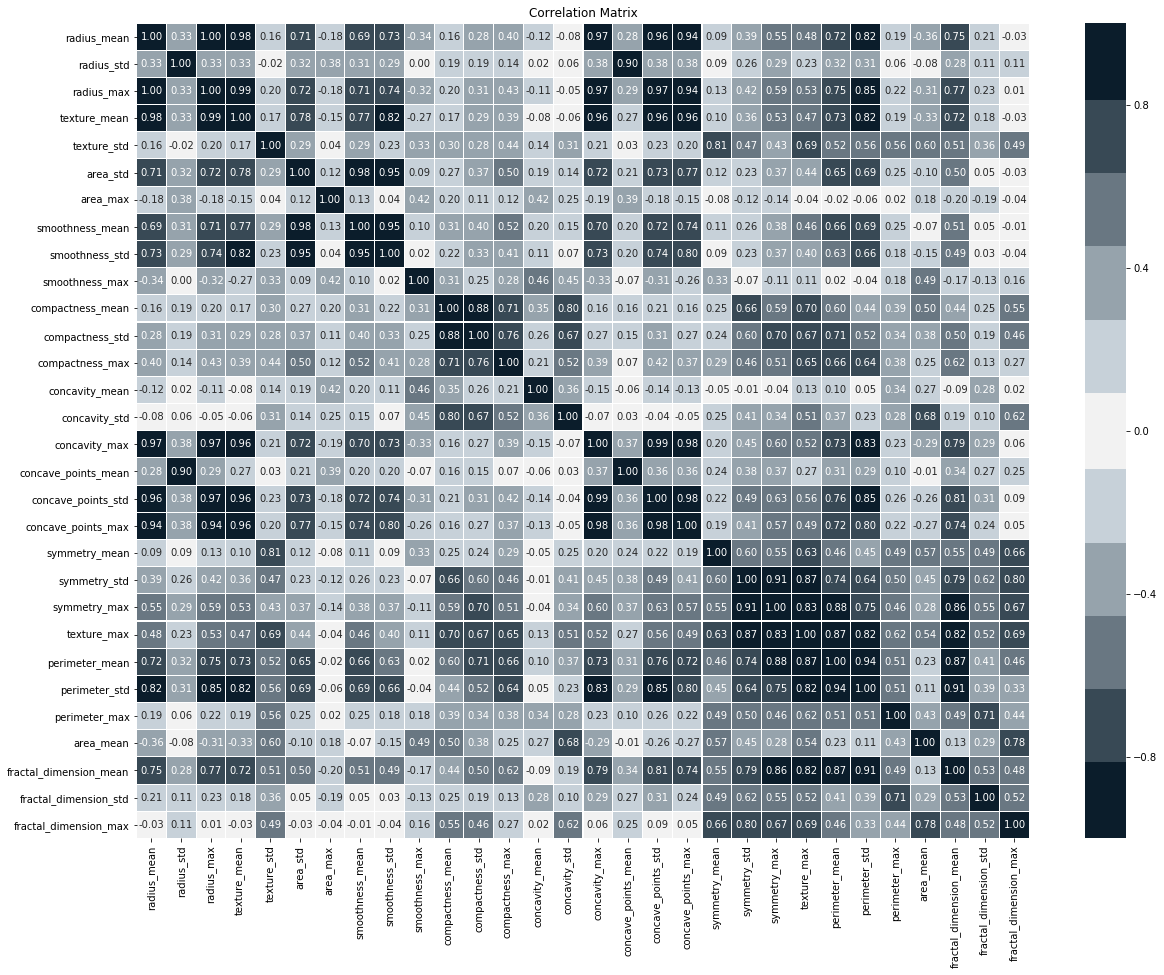

In [10]:
# Проверяем корреляцию между признаками c помощью теплокарты

correlation = X_train.corr()

fig, ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(h_neg=240, h_pos=240, l=10, n=11, center='light')
htm = sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, fmt='.2f',center=0,cmap=cmap,linewidths=.1, ax=ax)
htm.set_title('Correlation Matrix', fontsize=12, fontdict={})
htm

### После анализа теплокарты видим, что часть признаков сильно скоррелированы между собой. Т.к. при обучении такие признаки могут ухудшить качество модели, необходимо от них избавиться ###

In [11]:
# Определим список признаков, которые наиболее скоррелированы. В качестве порога возьмем коэффициент корреляции Пирсона > 0.9

cor_feature_names = []
for i in correlation:
    for j in correlation.index[correlation[i] > 0.91]:
        if i != j and j not in cor_feature_names and i not in cor_feature_names:
            cor_feature_names.append(j)
            print(f'{i} --> {j}: coef = {correlation[i][correlation.index==j].values[0]:.5f}') # вывод высокоскоррелированных признаков

radius_mean --> radius_max: coef = 0.99825
radius_mean --> texture_mean: coef = 0.98487
radius_mean --> concavity_max: coef = 0.96833
radius_mean --> concave_points_std: coef = 0.96500
radius_mean --> concave_points_max: coef = 0.93573
area_std --> smoothness_mean: coef = 0.98326
area_std --> smoothness_std: coef = 0.95475
perimeter_mean --> perimeter_std: coef = 0.93746


In [12]:
# Удаляем признаки с высокой корреляцией

drop_feature_names = cor_feature_names # список "грязных" фич с высокой корреляцией. Он понадобиться для предобработки X_test
X_train = X_train.drop(drop_feature_names, axis=1)

# Поиск выбросов #

Выбросы будем искать методом LOF для каждого класса отдельно

In [13]:
clf_lof = LOF(contamination=0.07) # 7,5% самых экстримальных семплов среди отицательных диагнозов считать выбросами
clf_lof.fit(X_train[y_train == 0])
y_train0_out_pred = clf_lof.labels_

clf_lof = LOF(contamination=0.05) # 5% самых экстримальных семплов среди положительных диагнозов считать выбросами
clf_lof.fit(X_train[y_train == 1])
y_train1_out_pred = clf_lof.labels_

In [14]:
# Объединим 2 списка предсказаний в один в соответствии с индексами основного ДатаСета

outliers_list = np.zeros(X_train.shape[0], dtype=int)
outliers_list[y_train == 0] = y_train0_out_pred
outliers_list[y_train == 1] = y_train1_out_pred

np.bincount(outliers_list) # Получилось суммарно 20 выбросов

array([265,  19], dtype=int64)

In [15]:
# Избавляемся от выбросов

X_train.drop(np.where(outliers_list == 1)[0], axis=0, inplace=True)
y_train.drop(np.where(outliers_list == 1)[0], axis=0,  inplace=True)

## Нормализуем признаки ##

In [16]:
feature_names = X_train.columns.values

In [17]:
std_scaler = StandardScaler()
X_train_norm = std_scaler.fit_transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, columns=feature_names)

## Произведем подсчет features importances ##

Слабые информационные признаки могут будут "зашумлять" модель при обучении.
Также их анализ увеличит объем ресурсов, требуемых для обработки

От таких признаком можно будет избавиться

In [18]:
rfc = RandomForestClassifier(max_depth=7, n_estimators=300)

print(cross_val_score(rfc, X_train_norm, y_train, cv=6, scoring='accuracy'))
print(np.mean(cross_val_score(rfc, X_train_norm, y_train, cv=6, scoring='accuracy')))

[1.         0.86666667 0.93333333 0.95454545 0.95348837 1.        ]
0.9438473886148304


### Проверяем важность признаков через собственный атрибут RandomForest ###

In [103]:
rfc.fit(X_train_norm, y_train)
imp_res1 = pd.DataFrame({
        'feature': feature_names[np.argsort(-rfc.feature_importances_)],
       'num_of_feature': np.argsort(-rfc.feature_importances_),
        'importance': -np.sort(-rfc.feature_importances_)})
imp_res1

,feature,num_of_feature,importance
0,fractal_dimension_mean,19,0.220592
1,perimeter_mean,16,0.133616
2,radius_mean,0,0.130964
3,symmetry_max,14,0.115651
4,area_std,3,0.104186
5,radius_std,1,0.036419
6,symmetry_std,13,0.035740
7,concave_points_mean,11,0.035515
8,texture_max,15,0.030981
9,fractal_dimension_std,20,0.027384


### Существует мнение, что собственный способ оценки важностей фич RandomForest не всего отображает значения корректно ### 
https://explained.ai/rf-importance/index.html

Поэтому воспользуемся вторым методом расчета - permutation feature importances из библиотеки rf-pimp, который оценивает важности через перестановку столбцов и последующую повторную оценку acurracy score.
С подключение OOB выборки для оценки точности качество оценки также должно повысится.

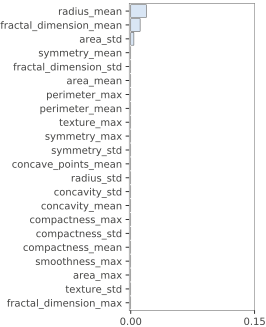

In [106]:
# Проверяем важность признаков с помощью библиотеки rf-pimp

imp_res2 = rf.importances(rfc, X_train_norm, y_train) # Расчет permutation feature importances для RandomForestClassifier
rf.plot_importances(imp_res2) # Отображение

Как видим, +/- расклад важности признаков стандартного метода и метода permutation совпадает

In [19]:
drop_feature_names2 = [
                      # 'fractal_dimension_max', 
                      # 'texture_std',
                       'area_max',
                       'compactness_mean',
                       'concavity_std'
                       ]

X_train_norm = X_train_norm.drop(drop_feature_names2, axis=1)
feature_names = X_train_norm.columns.values

In [108]:
# Проверим важность еще раз
rfc.fit(X_train_norm, y_train)
imp_res1 = pd.DataFrame({
        'feature': feature_names[np.argsort(-rfc.feature_importances_)],
       'num_of_feature': np.argsort(-rfc.feature_importances_),
        'importance': -np.sort(-rfc.feature_importances_)})
imp_res1 # Порядок не изменился значительно

,feature,num_of_feature,importance
0,fractal_dimension_mean,16,0.226710
1,radius_mean,0,0.171817
2,perimeter_mean,13,0.126558
3,area_std,3,0.112670
4,symmetry_max,11,0.094435
5,symmetry_std,10,0.041545
6,texture_max,12,0.040577
7,concave_points_mean,8,0.035429
8,radius_std,1,0.028395
9,fractal_dimension_std,17,0.021856


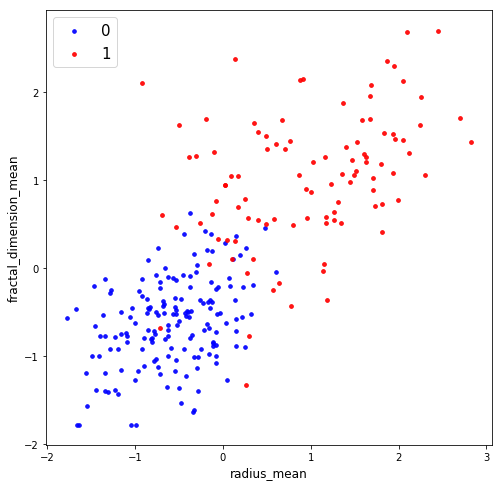

In [39]:
# Визуализируем отношения между двумя наиболее важными признаками

x = 0
y = 13

plt.figure(figsize=(8.0, 8.0))
plt.xlabel(feature_names[x],fontsize=12)
plt.ylabel(feature_names[y],fontsize=12)

category_0 = plt.scatter(X_train_norm.iloc[:, x][y_train.values == 0], X_train_norm.iloc[:, y][y_train.values == 0], c='blue', s=13, alpha=0.90)
category_1 = plt.scatter(X_train_norm.iloc[:, x][y_train.values == 1], X_train_norm.iloc[:, y][y_train.values == 1], c='red', s=14, alpha=0.90)

plt.legend((category_0, category_1), ('0', '1'), fontsize=15)

In [20]:
# Функция предобработки тестовой выборки, повторяющая шаги предобработки тренировочной

def prep_test(X):
    X_test_w = X.copy()
    X_test_w.drop('ID', axis=1, inplace=True)
    X_test_w.drop(cor_feature_names, axis=1, inplace=True)
    X_test_norm = std_scaler.transform(X_test_w)
    X_test_norm = pd.DataFrame(X_test_norm, columns=X_test_w.columns.values)
    X_test_norm = X_test_norm.drop(drop_feature_names2, axis=1)
    
    return X_test_norm

X_test_norm = prep_test(X_test)

In [21]:
cv = KFold(n_splits=3, shuffle=True)

In [22]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv, predict):
    """
    Computes meta-features using the classifier.
    
    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    if predict:
        X_meta_test = np.zeros(shape=(X_test.shape[0]), dtype=np.float32)
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        if predict:
            X_meta_test = X_meta_test + folded_clf.predict_proba(X_test)[:, 1]
            X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
        else:
            X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]

    if predict:
        X_meta_test = X_meta_test/cv.get_n_splits()
        print('X_meta_test ready for predictions')
    
    else:
        meta_clf = clone(clf)
        meta_clf.fit(X_train, y_train)
        X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
        print('X_meta_test ready for validation')
    
    return X_meta_train, X_meta_test

In [23]:
def generate_metafeatures(classifiers, X_train, X_test, y_train, cv, predict=False):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv, predict)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test


In [118]:
for n in [1, 2,3,4,5]:
    clf_tester = xgb.XGBClassifier(n_estimators=500, max_depth=n)
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n =', n)
    print(val_score)
    print(np.mean(val_score))

n = 1
[1.         0.94736842 0.88888889 1.         0.94736842 0.8
 1.         0.95238095 0.94736842 1.        ]
0.9483375104427736
n = 2
[1.         0.94736842 0.88888889 0.95238095 0.94736842 0.85714286
 1.         0.95238095 1.         1.        ]
0.9545530492898914
n = 3
[1.         0.94736842 0.88888889 0.95238095 0.88888889 0.85714286
 1.         0.9        1.         1.        ]
0.9434670008354219
n = 4
[1.         0.94736842 0.88888889 0.95238095 0.88888889 0.85714286
 1.         0.95238095 1.         1.        ]
0.9487050960735172
n = 5
[1.         0.94736842 0.88888889 0.95238095 0.88888889 0.85714286
 1.         0.9        1.         1.        ]
0.9434670008354219


In [43]:
for n in [80,90,100,150,200]:
    clf_tester = GradientBoostingClassifier(n_estimators=n, max_depth=3, max_features='sqrt')
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n = ', n)
    print(val_score)
    print('> ', np.mean(val_score))

n =  80
[1.         0.94736842 0.82352941 0.76190476 0.88888889 0.85714286
 1.         0.94736842 1.         1.        ]
>  0.9226202761806477
n =  90
[1.         0.94736842 0.82352941 0.81818182 0.94736842 0.85714286
 1.         0.94736842 1.         1.        ]
>  0.9340959350247277
n =  100
[0.95238095 0.94736842 0.88888889 0.7826087  0.94736842 0.85714286
 1.         0.94736842 1.         1.        ]
>  0.9323126657222767
n =  150
[1.         0.94736842 0.94736842 0.7826087  0.94736842 0.9
 1.         0.94736842 1.         1.        ]
>  0.94720823798627
n =  200
[1.         0.94736842 0.94736842 0.7826087  0.88888889 0.85714286
 1.         0.94736842 1.         1.        ]
>  0.9370745704841814


In [29]:
clf_tester = LogisticRegression(penalty='l2', C=0.4, solver='lbfgs', max_iter=2000, class_weight='balanced_subsample')
val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
print(val_score)
print(np.mean(val_score))

[1.         0.94736842 1.         1.         0.94736842 0.84210526
 1.         0.94736842 1.         1.        ]
0.9684210526315791


In [38]:
for n in [1]:
    clf_tester = SVC(C=n, probability=True, gamma='scale')
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n = ', n)
    print(val_score)
    print(np.mean(val_score))

n =  1
[1.         1.         1.         0.94736842 0.85714286 0.84210526
 1.         0.94736842 1.         1.        ]
0.9593984962406015


In [39]:
for n in [3]:
    clf_tester = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100)
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n = ', n)
    print(val_score)
    print(np.mean(val_score))

n =  3
[1.         0.57142857 0.9        0.94736842 0.9        0.8
 1.         0.94736842 1.         1.        ]
0.9066165413533834


In [146]:
for n in [2,3,4,5,6,7,8]:
    clf_tester = ExtraTreesClassifier(max_depth=n, n_estimators=300, bootstrap=True, class_weight='balanced_subsample')
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n = ', n)
    print(val_score)
    print(np.mean(val_score))

n =  2
[0.95238095 0.94736842 0.75       0.73684211 1.         0.8
 1.         0.94736842 1.         1.        ]
0.9133959899749373
n =  3
[0.95238095 0.94736842 0.75       0.76190476 0.95238095 0.8
 1.         0.9        1.         1.        ]
0.9064035087719298
n =  4
[0.95238095 0.94736842 0.88888889 0.76190476 0.95238095 0.8
 1.         0.85714286 1.         1.        ]
0.9160066833751044
n =  5
[0.95238095 0.94736842 0.88888889 0.9        0.9        0.84210526
 1.         0.9        1.         1.        ]
0.9330743525480368
n =  6
[0.95238095 0.94736842 0.88888889 0.9        0.95238095 0.84210526
 1.         0.94736842 1.         1.        ]
0.9430492898913952
n =  7
[0.95238095 0.94736842 0.88888889 0.85714286 0.95238095 0.84210526
 1.         0.94736842 1.         1.        ]
0.9387635756056809
n =  8
[0.95238095 0.94736842 0.88888889 0.9        0.9        0.88888889
 1.         0.94736842 1.         1.        ]
0.9424895572263994


In [55]:
list1 = []
list10 = []
list100 = []

for state in range(11):
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_norm, y_train, test_size=0.20, shuffle=True, random_state=state)

    warnings.filterwarnings('ignore')

    sv = SVC(C=1, probability=True, gamma='scale')
    rf = ExtraTreesClassifier(max_depth=n, n_estimators=300, bootstrap=True, class_weight='balanced_subsample')
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100)
    xg = xgb.XGBClassifier(n_estimators=500, max_depth=2)
    grad = GradientBoostingClassifier(n_estimators=150, max_depth=3, max_features='sqrt')
    lr = LogisticRegression(solver='lbfgs') # Стандартная логистическая регрессия
    lrl2 = LogisticRegression(penalty='l2', C=0.4, class_weight='balanced', solver='lbfgs') # Логистическая регрессия с L2-регуляризацией и сбалансированностью классов, т.к. больных меньше, чем здоровых
    lrl1 = LogisticRegression(penalty='l1', C=1, class_weight='balanced')

    clf_array = [
                # sv, 
                # rf,                      # !
                 ada,
                # xg,
                # grad,
                # cat,
                # lr,                       # !
                 lrl2,
                # lrl1
                ]

    stacked_features_train, stacked_features_test = generate_metafeatures(clf_array, X_train_split.values, X_test_split.values, y_train_split.values, cv)
    print('random state = ', state)
    
    total_features_train = np.hstack([X_train_split, stacked_features_train])
    total_features_test = np.hstack([X_test_split, stacked_features_test])
    
    for n, c in enumerate([0.1, 1, 10, 100]):
        clf_meta = LogisticRegression(solver='lbfgs', penalty='l2', C=c)
        clf_meta.fit(stacked_features_train, y_train_split)
        y_pred = clf_meta.predict(stacked_features_test)
        f1 = f1_score(y_test_split, y_pred)
        if c == 1:
            list1.append(f1)
        if c == 10:
            list10.append(f1)
        if c == 100:
            list100.append(f1)
        print(f'{c}, f1 = {f1:.5f}')
print('C1 = ', np.mean(list1))
print('C10 = ', np.mean(list10))
print('C100 = ', np.mean(list100))

  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:01<00:01,  1.30s/it]

X_meta_test ready for validation


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


random state =  0
0.1, f1 = 1.00000
1, f1 = 1.00000
10, f1 = 1.00000
100, f1 = 1.00000


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  2.26it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  4.35it/s]


random state =  1
0.1, f1 = 0.90476
1, f1 = 0.90476
10, f1 = 0.90476
100, f1 = 0.93023


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.31it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


random state =  2
0.1, f1 = 0.96970
1, f1 = 0.96970
10, f1 = 0.96970
100, f1 = 0.96970


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:01<00:01,  1.30s/it]

X_meta_test ready for validation


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


random state =  3
0.1, f1 = 0.94737
1, f1 = 0.97436
10, f1 = 0.97436
100, f1 = 0.97436


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.38it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


random state =  4
0.1, f1 = 0.94340
1, f1 = 0.94340
10, f1 = 0.94340
100, f1 = 0.94340


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:01<00:01,  1.02s/it]

X_meta_test ready for validation


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


random state =  5
0.1, f1 = 0.96000
1, f1 = 0.96000
10, f1 = 0.96000
100, f1 = 0.96000


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.12it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


random state =  6
0.1, f1 = 0.92308
1, f1 = 0.92308
10, f1 = 0.95000
100, f1 = 0.95000


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.05it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


random state =  7
0.1, f1 = 0.95652
1, f1 = 0.95652
10, f1 = 0.97872
100, f1 = 0.97872


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:01<00:01,  1.27s/it]

X_meta_test ready for validation


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


random state =  8
0.1, f1 = 0.98039
1, f1 = 0.98039
10, f1 = 0.98039
100, f1 = 0.98039


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:01<00:01,  1.23s/it]

X_meta_test ready for validation


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


random state =  9
0.1, f1 = 0.93333
1, f1 = 0.93333
10, f1 = 0.96774
100, f1 = 0.96774


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:01<00:01,  1.07s/it]

X_meta_test ready for validation


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


random state =  10
0.1, f1 = 0.96552
1, f1 = 0.96552
10, f1 = 1.00000
100, f1 = 1.00000
C1 =  0.9555504971832445
C10 =  0.9662792338031707
C100 =  0.9685947477465917


# РЕШЕНИЕ #

In [56]:
sv = SVC(C=3, probability=True, gamma='scale')
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=200)
et = ExtraTreesClassifier(max_depth=9, n_estimators=400, bootstrap=True, class_weight='balanced_subsample')
xg = xgb.XGBClassifier(n_estimators=500, max_depth=2)
lr = LogisticRegression(solver='lbfgs') # Стандартная логистическая регрессия
lrl2 = LogisticRegression(penalty='l2', C=0.4, class_weight='balanced', solver='lbfgs') # Логистическая регрессия с L2-регуляризацией и сбалансированностью классов, т.к. больных меньше, чем здоровых

clf_array = [
            # sv,
            ada,
            # et,                      # !
            # xg,
            # lr,                       # !
             lrl2
            ]

stacked_features_train, stacked_features_test = generate_metafeatures(clf_array, X_train_norm.values, X_test_norm.values, y_train.values, cv=cv)

clf_meta = LogisticRegression(penalty='l2', C=100, solver='lbfgs')
clf_meta.fit(stacked_features_train, y_train)
y_pred = clf_meta.predict(stacked_features_test)

  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:01<00:01,  1.46s/it]

X_meta_test ready for validation


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Обработка результата

In [57]:
y_pred = y_pred.astype(int)

In [58]:
submission = pd.DataFrame(y_pred, columns=['Category'], index=None)
subission_sample = pd.read_csv(filepath_or_buffer=r'C:\Users\OlegD\Desktop\Machine Learning\mid-term hackaton\submission_sample.csv')
submission = pd.concat([subission_sample['ID'], submission], axis=1, sort=False)
submission.to_csv(path_or_buf=r'C:\Users\OlegD\Desktop\Machine Learning\mid-term hackaton\submission5-ada+lr2-c100(2).csv', index=None)
submission.head()

,ID,Category
0,8915,0
1,91376702,0
2,8710441,0
3,871641,0
4,873592,1
